# 0. Importing the libs and read the data

In [140]:
# Core Libraries
import numpy as np
import pandas as pd
import json
import os
import glob
import traceback

# Plotting Libraries
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.ticker as mticker
from statistics import mode

from collections import Counter

# 1. Data preparation and data cleaning

### Loading the JSON files

In [ ]:
dataset_base_path = "./data/"
# Find all JSON files in the specified path using glob
json_files = glob.glob(os.path.join(dataset_base_path, "*.json"))
json_files.sort() # Sort for consistent ordering if needed

num_files = len(json_files)
print(f"Found {num_files} JSON files in: {dataset_base_path}")

if num_files == 0:
    print("\n--- WARNING ---")
    print("No JSON files found. Please ensure the 'dataset_base_path' is correct and points to the folder containing the JSON files.")
else:
    print("\nFirst 5 sample file names:")
    for f in json_files[:min(5, num_files)]:
        print(f" - {os.path.basename(f)}")

Found 1219 JSON files in: ./data/

First 5 sample file names:
 - 00054cee-9818-4ced-ad0d-e231ce7991bd.json
 - 00261196-1a36-4b41-ade6-fd4f355d3faf.json
 - 0036dcf5-04f2-4fe1-81a7-34527d6fe618.json
 - 0042e5d0-8484-49d3-8744-151c14bbbb9a.json
 - 00617f39-fe99-49a5-a89e-83c2e2b6fad1.json


### Converted all JSON keys to lowercase
- I did this because I see that there are some columns keys that contain uppercase letters and this confused me in my analysis

In [ ]:
def lowercase_keys(obj):
    """Recursively convert all dictionary keys to lowercase"""
    if isinstance(obj, dict):
        return {key.lower(): lowercase_keys(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [lowercase_keys(item) for item in obj]
    else:
        return obj

files_changed = 0
for file_path in json_files:
    try:
        # Read the JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Convert all keys to lowercase
        lowercase_data = lowercase_keys(data)
        
        # Check if data was changed
        if lowercase_data != data:
            files_changed += 1
            # Write back to file
            with open(file_path, 'w') as f:
                json.dump(lowercase_data, f, indent=2)
            print(f"{os.path.basename(file_path)} (modified)")    
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
print(f"{files_changed}/{len(json_files)} file changes")

### Range and Vales type check
- Check if the type of the values are consistent

| COLUMN      | TYPE           |
|-------------|----------------|
| time        | STRING         |
| open        | FLOAT          |
| high        | FLOAT          |
| low         | FLOAT          |
| close       | FLOAT          |
| volume      | INTEGER        |
| price       | FLOAT          |
| start_date  | DATETIME + UTC |
| end_date    | DATETIME + UTC |
| start_price | FLOAT          |
| end_price   | FLOAT          |

- Check if date `start_date` and `end_date` are in the chandles range of values
- Check if the `open`, `high`, `low`, `close` and `price` are in the range of the [min, max] range of the values

In [59]:
errors = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    ohlcv = data['ohlcv_data']
    labels = data['labels']
    
    dates = [pd.to_datetime(c['time'], utc=True) for c in ohlcv]
    prices = [float(c[k]) for c in ohlcv for k in ['open', 'high', 'low', 'close']]
    min_d, max_d = min(dates), max(dates)
    min_p, max_p = min(prices), max(prices)
    
    # Check OHLCV types
    for i, c in enumerate(ohlcv):
        # TIME
        if not isinstance(c['time'], str):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] time: {type(c['time']).__name__} (expected str)")
        
        # OPEN
        if not isinstance(float(c['open']), float):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] open not convertible to float")
        if not (min_p <= float(c['open']) <= max_p):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] open {float(c['open'])} outside ({min_p}, {max_p})")
        
        # HIGH
        if not isinstance(float(c['high']), float):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] high not convertible to float")
        if not (min_p <= float(c['high']) <= max_p):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] high {float(c['high'])} outside ({min_p}, {max_p})")

        # LOW
        if not isinstance(float(c['low']), float):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] low not convertible to float")
        if not (min_p <= float(c['low']) <= max_p):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] low {float(c['low'])} outside ({min_p}, {max_p})")

        # CLOSE
        if not isinstance(float(c['close']), float):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] close not convertible to float")
        if not (min_p <= float(c['close']) <= max_p):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] close {float(c['close'])} outside ({min_p}, {max_p})")

        # VOLUME
        if not isinstance(int(float(c['volume'])), int):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] volume not convertible to int")
    
    # Check horizontal lines
    for i, hl in enumerate(labels.get('horizontal_lines', [])):
        if not isinstance(float(hl['price']), float):
            errors.append(f"{os.path.basename(file_path)} HLine[{i}] price not convertible to float")
        if not (min_p <= float(hl['price']) <= max_p):
            errors.append(f"{os.path.basename(file_path)} OHLCV[{i}] price {float(hl['price'])} outside ({min_p}, {max_p})")
    
    # Check ray lines
    for i, rl in enumerate(labels.get('ray_lines', [])):
        start_d = pd.to_datetime(rl['start_date'], utc=True)
        end_d = pd.to_datetime(rl['end_date'], utc=True)
        if not (min_d <= start_d <= max_d):
            errors.append(f"{os.path.basename(file_path)} RLine[{i}] start_date {start_d} outside ({min_d}, {max_d})")
        if not (min_d <= end_d <= max_d):
            errors.append(f"{os.path.basename(file_path)} RLine[{i}] end_date {end_d} outside ({min_d}, {max_d})")
        if not isinstance(float(rl['start_price']), float):
            errors.append(f"{os.path.basename(file_path)} RLine[{i}] start_price not convertible to float")
        if not isinstance(float(rl['end_price']), float):
            errors.append(f"{os.path.basename(file_path)} RLine[{i}] end_price not convertible to float")

print(f"\n{'='*60}")
print(f"Total errors found: {len(errors)}")
print(f"{'='*60}")
for err in errors:
    print(f"{err}")


Total errors found: 259
08f99090-f3a9-4dd6-b803-711d6f81b63c.json OHLCV[7] price 15.613468857835594 outside (14.379117854997432, 15.556979806513924)
0cad3727-23a4-4a71-9825-ca8dc9456f12.json OHLCV[1] price 11.852911403725145 outside (8.671898048059377, 11.75198742541171)
0cfa3e4b-a6b6-4faa-88a2-741019cf37c8.json OHLCV[6] price 45.434289374156954 outside (45.436513636804165, 57.74926113588138)
0dddd5a9-d4a0-4a43-879a-81d95f95d83e.json OHLCV[1] price 16.866650440763593 outside (12.340079837987235, 16.226623821497736)
0f21276b-b7c2-483e-b6ab-583b58d1daab.json OHLCV[8] price 2.0041140697016058 outside (2.033183185444329, 2.4789974387311253)
10fb43a4-5190-467c-a051-df593f91be43.json OHLCV[9] price 45.18507442313963 outside (45.23169341280242, 58.91897572631759)
116e56cf-4d39-48c6-8868-6c8cc0598c01.json OHLCV[8] price 4.367677663022713 outside (3.87973658756021, 4.337809243694331)
19d13276-bed8-4265-aecc-5ceefc513bb0.json OHLCV[6] price 50.57926748569325 outside (50.581683211714044, 64.8181

### - Converting the `start_date` and `end_date` columns that are outside the range of the chandles stick to max and min values from the chandles date range
### - Converting the `price` that is outside the range [`low`, `high`] to the lowest or the highes value

In [60]:
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    ohlcv = data['ohlcv_data']
    labels = data['labels']
    
    dates = [pd.to_datetime(c['time'], utc=True) for c in ohlcv]
    prices = [float(c[k]) for c in ohlcv for k in ['open', 'high', 'low', 'close']]
    min_d, max_d = min(dates), max(dates)
    min_p, max_p = min(prices), max(prices)
        
    # Check horizontal lines
    for hl in labels.get('horizontal_lines', []):
        if not (min_p <= float(hl['price']) <= max_p):
            hl['price'] = max(min_p, min(float(hl['price']), max_p))
    
    # Check and fix ray lines
    for rl in labels.get('ray_lines', []):
        start_d = pd.to_datetime(rl['start_date'], utc=True)
        end_d = pd.to_datetime(rl['end_date'], utc=True)

        if not (min_d <= start_d <= max_d):        
            start_d = max(min_d, min(start_d, max_d))
        if not (min_d <= end_d <= max_d):
            end_d = max(min_d, min(end_d, max_d))
        
        rl['start_date'] = start_d.isoformat()
        rl['end_date'] = end_d.isoformat()
    
    # Save fixed data
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=2)

### Check if there are missing lines in the image of the chart
- This will be the data that will enter to test

In [85]:
empty_h_files = 0
empty_r_files = 0
empty_both_files = 0
files_empty_h = []
files_empty_r = []
files_empty_both = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)

    labels = data.get("labels", {})

    h_lines = labels.get("horizontal_lines", [])
    r_lines = labels.get("ray_lines", [])

    filename = os.path.basename(file_path)

    if not h_lines:
        empty_h_files += 1
        files_empty_h.append(filename)

    if not r_lines:
        empty_r_files += 1
        files_empty_r.append(filename)

    if not h_lines and not r_lines:
        empty_both_files += 1
        files_empty_both.append(filename)

files_with_any_empty = set(files_empty_h) | set(files_empty_r)
print("Empty label statistics:")
print(f"Files with EMPTY horizontal_lines: {empty_h_files}/{len(json_files)} -- {100 * empty_h_files / len(json_files):.2f}%")
print(f"Files with EMPTY ray_lines:        {empty_r_files}/{len(json_files)} - {100 * empty_r_files / len(json_files):.2f}%")
print(f"Files with BOTH empty:             {empty_both_files}/{len(json_files)} -- {100 * empty_both_files / len(json_files):.2f}%")
print(f"Total with AT LEAST ONE EMPTY:     "f"{len(files_with_any_empty)}/{len(json_files)} - {100 * len(files_with_any_empty) / len(json_files):.2f}%")

Empty label statistics:
Files with EMPTY horizontal_lines: 26/1219 -- 2.13%
Files with EMPTY ray_lines:        190/1219 - 15.59%
Files with BOTH empty:             26/1219 -- 2.13%
Total with AT LEAST ONE EMPTY:     190/1219 - 15.59%


In [78]:
print("\nFirst 5 files with no horizontal lines:")
print(files_empty_h[:5])

print("\nFirst 5 files with no ray lines:")
print(files_empty_r[:5])

print("\nFirst 5 completely unlabeled files:")
print(files_empty_both[:5])


First 5 files with no horizontal lines:
['0e027a54-9d42-4cd2-8050-1b79575feddf.json', '103b10a5-0e9a-4f8c-b640-1d77dd904ebf.json', '1621e152-2850-491c-8821-48400def59dd.json', '19f9ef22-5435-48df-9df4-68db43fc3da4.json', '1a247043-c4f1-455c-9386-9a949b46feda.json']

First 5 files with no ray lines:
['00617f39-fe99-49a5-a89e-83c2e2b6fad1.json', '02eb35dd-90a4-46da-aa15-2b985d64df61.json', '03dda0d5-b962-46ef-9f22-bed2e7915163.json', '0583fe53-e6fb-4269-a827-dbd250c423e0.json', '0587dd17-e4c6-4a9b-816e-f9bbfaf4b74a.json']

First 5 completely unlabeled files:
['0e027a54-9d42-4cd2-8050-1b79575feddf.json', '103b10a5-0e9a-4f8c-b640-1d77dd904ebf.json', '1621e152-2850-491c-8821-48400def59dd.json', '19f9ef22-5435-48df-9df4-68db43fc3da4.json', '1a247043-c4f1-455c-9386-9a949b46feda.json']


### Label Count


Processed 1219/1219 files.


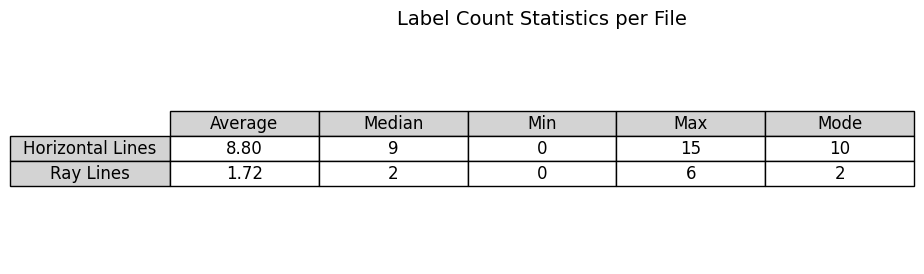

In [61]:
h_line_counts = []
r_line_counts = []
processed_files_stats = 0
error_files_stats = 0

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    labels = data.get('labels', {})

    # Store counts for statistics
    h_count = len(labels.get('horizontal_lines', []))
    r_count = len(labels.get('ray_lines', []))
    h_line_counts.append(h_count)
    r_line_counts.append(r_count)
    processed_files_stats += 1

print(f"\nProcessed {processed_files_stats}/{len(json_files)} files.")

stats = {
    "Horizontal Lines": [
        f"{np.mean(h_line_counts):.2f}",
        f"{int(np.median(h_line_counts))}",
        f"{np.min(h_line_counts)}",
        f"{np.max(h_line_counts)}",
        f"{mode(h_line_counts)}"
    ],
    "Ray Lines": [
        f"{np.mean(r_line_counts):.2f}",
        f"{int(np.median(r_line_counts))}",
        f"{np.min(r_line_counts)}",
        f"{np.max(r_line_counts)}",
        f"{mode(r_line_counts)}"
    ]
}

rows = ["Average", "Median", "Min", "Max", "Mode"]

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
table = ax.table(
    cellText=[stats["Horizontal Lines"], stats["Ray Lines"]],
    rowLabels=["Horizontal Lines", "Ray Lines"],
    colLabels=rows,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

# Color the header row and column gray
for (row, col), cell in table.get_celld().items():
    if row == 0 or col == -1:
        cell.set_facecolor('#d3d3d3')

plt.title("Label Count Statistics per File", fontsize=14)
plt.show()

### Distribution of Hirizontal and Ray lines

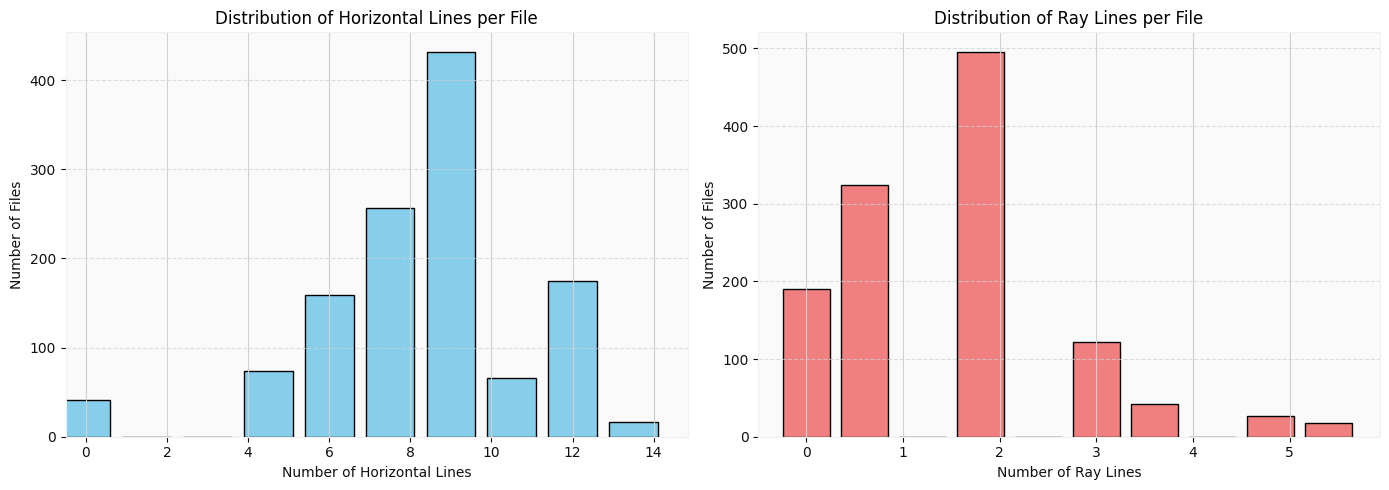

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for Horizontal Lines
axes[0].hist(h_line_counts, align='left', rwidth=0.8, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Horizontal Lines per File')
axes[0].set_xlabel('Number of Horizontal Lines')
axes[0].set_ylabel('Number of Files')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[0].set_xlim(left=-0.5)

# Histogram for Ray Lines
axes[1].hist(r_line_counts, align='left', rwidth=0.8, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Ray Lines per File')
axes[1].set_xlabel('Number of Ray Lines')
axes[1].set_ylabel('Number of Files')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
axes[1].set_xlim(left=-0.5)

plt.tight_layout()
plt.show()

### Loading some sample images


=== Visualizing file 1/4 ===
Loading: 00054cee-9818-4ced-ad0d-e231ce7991bd.json
Loaded data: 300 candles, 8 h-lines, 4 r-lines.


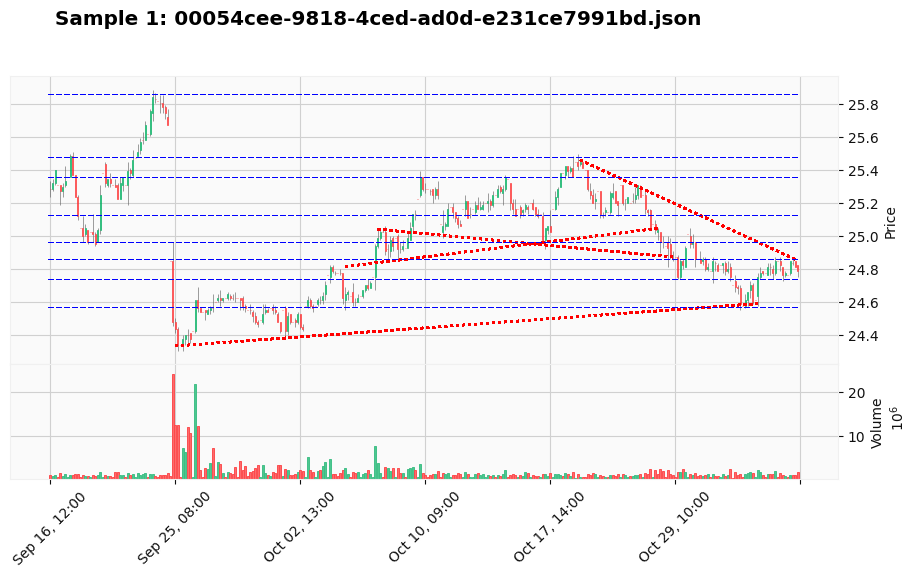


=== Visualizing file 2/4 ===
Loading: 00261196-1a36-4b41-ade6-fd4f355d3faf.json
Loaded data: 300 candles, 5 h-lines, 3 r-lines.


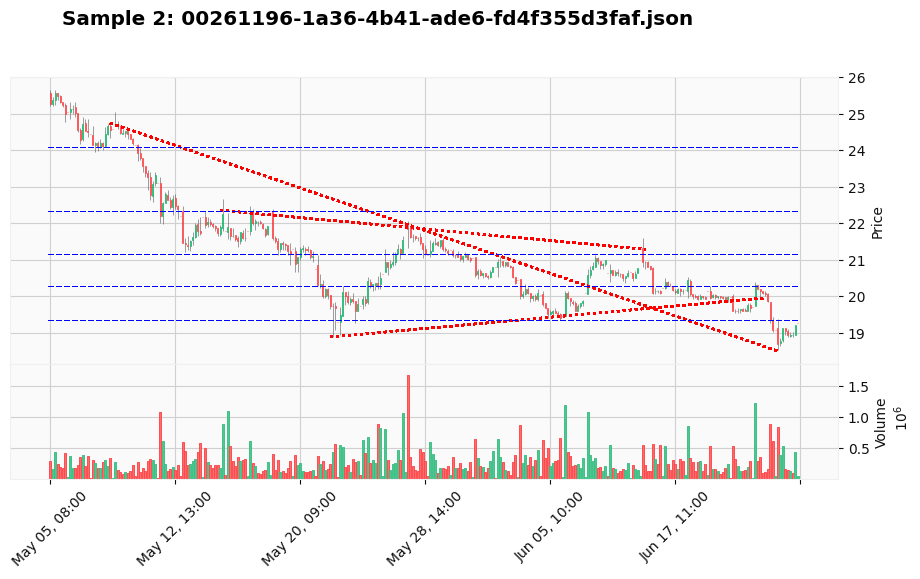


=== Visualizing file 3/4 ===
Loading: 0036dcf5-04f2-4fe1-81a7-34527d6fe618.json
Loaded data: 300 candles, 8 h-lines, 2 r-lines.


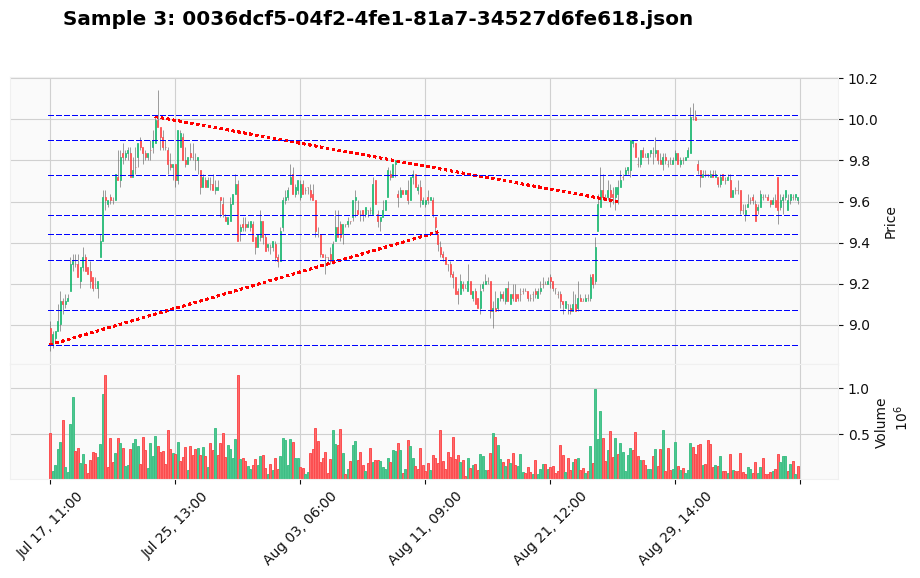


=== Visualizing file 4/4 ===
Loading: 0042e5d0-8484-49d3-8744-151c14bbbb9a.json
Loaded data: 300 candles, 9 h-lines, 2 r-lines.


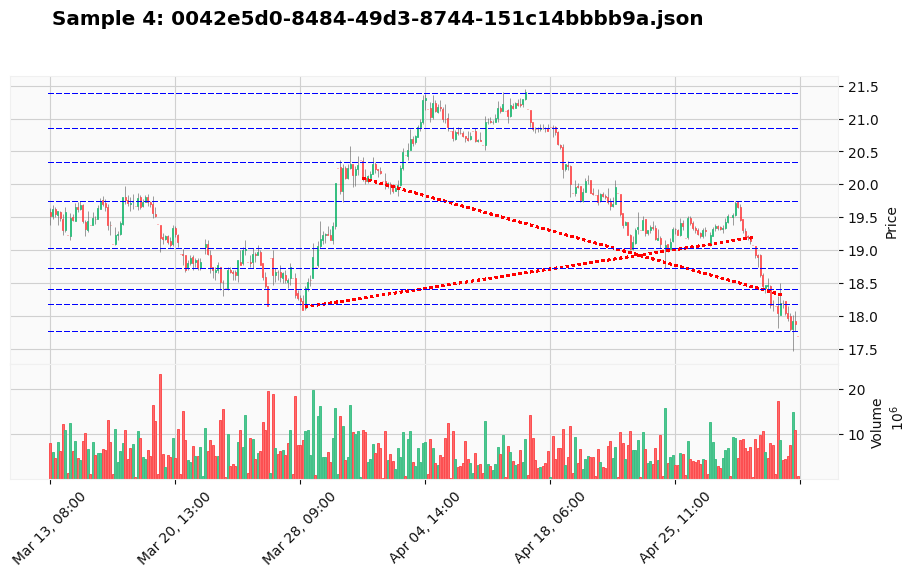

In [ ]:
for i, sample_file_path in enumerate(json_files[:4], 1):
    print(f"\n=== Visualizing file {i}/4 ===")
    print(f"Loading: {os.path.basename(sample_file_path)}")

    with open(sample_file_path, 'r') as f:
        data = json.load(f)

    metadata = data.get('metadata', {})
    ohlcv_data = data.get('ohlcv_data', [])
    labels = data.get('labels', {})
    horizontal_lines = labels.get('horizontal_lines', [])
    ray_lines = labels.get('ray_lines', [])

    print(f"Loaded data: {len(ohlcv_data)} candles, "
          f"{len(horizontal_lines)} h-lines, {len(ray_lines)} r-lines.")

    if not ohlcv_data:
        print("No OHLCV data, skipping.")
        continue

    df = pd.DataFrame(ohlcv_data)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)
    df['volume'] = df['volume'].fillna(0).astype(np.int64)

    # ---- labels ----
    hlines_plot = [
        float(h['price']) for h in horizontal_lines
        if 'price' in h
    ]

    alines_plot = []
    for r in ray_lines:
        alines_plot.append([
            (pd.to_datetime(r['start_date']), float(r['start_price'])),
            (pd.to_datetime(r['end_date']), float(r['end_price']))
        ])

    chart_title = f"Sample {i}: {os.path.basename(sample_file_path)}"

    plot_kwargs = dict(
        type='candle',
        volume=True,
        style='yahoo',
        title=chart_title,
        ylabel='Price',
        ylabel_lower='Volume',
        figratio=(14, 7),
        figscale=1.0,
        hlines=dict(
            hlines=hlines_plot,
            colors='blue',
            linestyle='--',
            linewidths=1
        ) if hlines_plot else None,
        alines=dict(
            alines=alines_plot,
            colors='red',
            linestyle=':',
            linewidths=1.5
        ) if alines_plot else None
    )

    plot_kwargs = {k: v for k, v in plot_kwargs.items() if v is not None}

    mpf.plot(df, **plot_kwargs)
    plt.show()


### Loading the train data
- Helper function to load data

In [80]:
def loading_json_to_png_chart(output_folder, json_files):
    for idx, sample_file_path in enumerate(json_files[:len(json_files)]):
        print(f"\n[{idx+1}/{len(json_files)}] Processing: {os.path.basename(sample_file_path)}")

        try:
            with open(sample_file_path, 'r') as f:
                data = json.load(f)

            metadata = data.get('metadata', {})
            ohlcv_data = data.get('ohlcv_data', [])
            labels = data.get('labels', {})
            horizontal_lines = labels.get('horizontal_lines', [])
            ray_lines = labels.get('ray_lines', [])

            # Convert to DataFrame
            df = pd.DataFrame(ohlcv_data)
            df['time'] = pd.to_datetime(df['time'])
            df.set_index('time', inplace=True)

            for col in ['open', 'high', 'low', 'close', 'volume']:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)

            if df.empty:
                print("DataFrame empty after cleaning, skipping this file.")
                continue

            # Prepare horizontal lines
            hlines_plot = [float(hl['price']) for hl in horizontal_lines if 'price' in hl]

            # Prepare ray lines
            alines_plot = []
            for rl in ray_lines:
                try:
                    start_dt = pd.to_datetime(rl.get('start_date'))
                    end_dt = pd.to_datetime(rl.get('end_date'))
                    start_p = float(rl.get('start_price'))
                    end_p = float(rl.get('end_price'))

                    # Align timezone if needed
                    if df.index.tz is not None:
                        if start_dt.tz is None: start_dt = start_dt.tz_localize(df.index.tz)
                        else: start_dt = start_dt.tz_convert(df.index.tz)
                        if end_dt.tz is None: end_dt = end_dt.tz_localize(df.index.tz)
                        else: end_dt = end_dt.tz_convert(df.index.tz)

                    alines_plot.append([(start_dt, start_p), (end_dt, end_p)])
                except Exception as e:
                    print(f"  - Warning: Error processing ray line {rl}: {e}")

            # Chart title and save path
            base_name = os.path.basename(sample_file_path).replace('.json', '')
            chart_title = f"Sample Chart {idx+1}: {base_name}"
            save_path = os.path.join(output_folder, f"{base_name}.png")

            plot_kwargs = dict(
                type='candle',
                volume=True,
                style='yahoo',
                title=chart_title,
                ylabel='Price',
                ylabel_lower='Volume',
                figratio=(14, 7),
                figscale=1.0,
                hlines=dict(hlines=hlines_plot, colors='blue', linestyle='--', linewidths=1) if hlines_plot else None,
                alines=dict(alines=alines_plot, colors='red', linestyle=':', linewidths=1.5) if alines_plot else None,
                savefig=save_path
            )
            # Remove None kwargs
            plot_kwargs = {k: v for k, v in plot_kwargs.items() if v is not None}

            # Ensure volume is integer
            if 'volume' in df.columns:
                df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0).astype(np.int64)

            mpf.plot(df, **plot_kwargs)
            print(f"Saved chart to: {save_path}")

        except Exception as e:
            print(f"Error processing file {sample_file_path}: {e}")
            print(traceback.format_exc())

### Load all the charts

In [105]:
# Loading all the data
# loading_json_to_png_chart("data_charts", json_files)

### Load only the charts that have horizontal and ray lines 

In [110]:
# Loading only the training data (json_files - files_empty_h - files_empty_r - files_empty_both)
loading_json_to_png_chart("data_charts_training", list(set(json_files) - set(files_with_any_empty)))


[1/1219] Processing: 74b8f091-c1ec-48c3-9181-97fcc1db688d.json
Saved chart to: data_charts_training/74b8f091-c1ec-48c3-9181-97fcc1db688d.png

[2/1219] Processing: 05d8f260-b86f-4801-bec5-594e02aaa8e0.json
Saved chart to: data_charts_training/05d8f260-b86f-4801-bec5-594e02aaa8e0.png

[3/1219] Processing: 53fdd1c6-6e49-4e58-b9d1-23ecb9c3d326.json
Saved chart to: data_charts_training/53fdd1c6-6e49-4e58-b9d1-23ecb9c3d326.png

[4/1219] Processing: e86e6982-b8c9-4860-b22d-1f8bfdba2d38.json
Saved chart to: data_charts_training/e86e6982-b8c9-4860-b22d-1f8bfdba2d38.png

[5/1219] Processing: c3914b78-875c-4f6e-acf7-0d423139ec8b.json
Saved chart to: data_charts_training/c3914b78-875c-4f6e-acf7-0d423139ec8b.png

[6/1219] Processing: 0d6748fd-1db0-4083-ad7e-6cc718ab0577.json
Saved chart to: data_charts_training/0d6748fd-1db0-4083-ad7e-6cc718ab0577.png

[7/1219] Processing: 9df071f4-559f-4f1f-b9c9-ea14b8d19e9e.json
Saved chart to: data_charts_training/9df071f4-559f-4f1f-b9c9-ea14b8d19e9e.png

[8/12

### Load the charts that do not have horizontal or ray lines

In [111]:
# Loading only the test data (files_with_any_empty)
loading_json_to_png_chart("data_charts_test", list('./data/' + i for i in files_with_any_empty))


[1/190] Processing: 1feed113-c816-47b1-abf9-5b4ccbd00b08.json
Saved chart to: data_charts_test/1feed113-c816-47b1-abf9-5b4ccbd00b08.png

[2/190] Processing: e138c0cc-92d1-45c9-907b-5dfbace4ec75.json
Saved chart to: data_charts_test/e138c0cc-92d1-45c9-907b-5dfbace4ec75.png

[3/190] Processing: ffd6a172-2aee-4e16-a3d4-afe19593b389.json
Saved chart to: data_charts_test/ffd6a172-2aee-4e16-a3d4-afe19593b389.png

[4/190] Processing: 7c3a1812-16f9-4b8b-8fb5-5ddeb6021a39.json
Saved chart to: data_charts_test/7c3a1812-16f9-4b8b-8fb5-5ddeb6021a39.png

[5/190] Processing: d96d61da-9f1d-4e25-bba4-efba0786e259.json
Saved chart to: data_charts_test/d96d61da-9f1d-4e25-bba4-efba0786e259.png

[6/190] Processing: 9541360c-4674-484e-9ee6-bdf518f77ce5.json
Saved chart to: data_charts_test/9541360c-4674-484e-9ee6-bdf518f77ce5.png

[7/190] Processing: 9766064f-5f8d-4f20-995e-95bd7fdffc4c.json
Saved chart to: data_charts_test/9766064f-5f8d-4f20-995e-95bd7fdffc4c.png

[8/190] Processing: 3c9f6b05-53b6-4259-b

# Exploratory Data Analysis

### Year and Weekdays distribution of chandles

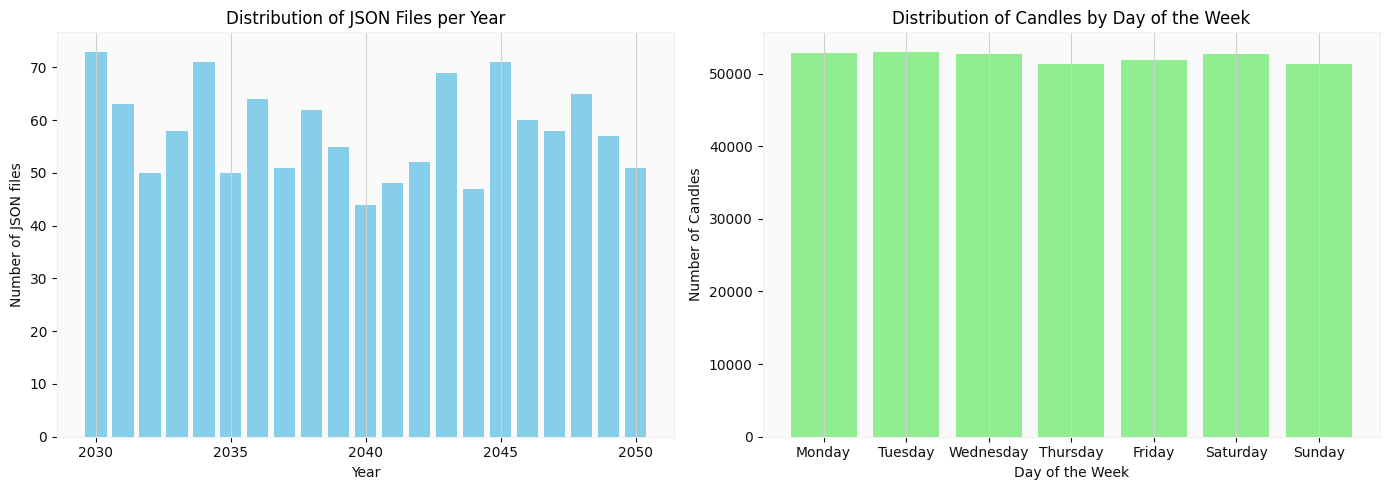

In [ ]:
years = []
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    ohlcv = data.get("ohlcv_data", [])
    if not ohlcv:
        continue
    first_time = pd.to_datetime(ohlcv[0]["time"])
    years.append(first_time.year)

year_counts = Counter(years)

# ---- Collect weekday data ----
weekdays = []
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    for candle in data.get("ohlcv_data", []):
        dt = pd.to_datetime(candle["time"])
        weekdays.append(dt.day_name())

# Order weekdays correctly
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_counts = Counter(weekdays)
weekday_values = [weekday_counts.get(day, 0) for day in order]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Plot 1: JSONs per year
axes[0].bar(year_counts.keys(), year_counts.values(), color='skyblue')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of JSON files")
axes[0].set_title("Distribution of JSON Files per Year")
axes[0].grid(axis="y")

# Plot 2: Candles per weekday
axes[1].bar(order, weekday_values, color='lightgreen')
axes[1].set_xlabel("Day of the Week")
axes[1].set_ylabel("Number of Candles")
axes[1].set_title("Distribution of Candles by Day of the Week")
axes[1].grid(axis="y")

plt.tight_layout()
plt.show()


### Time span per JSON
**How long is each sample?**
- Histogram of (last_time - first_time)
- Spot short / long windows

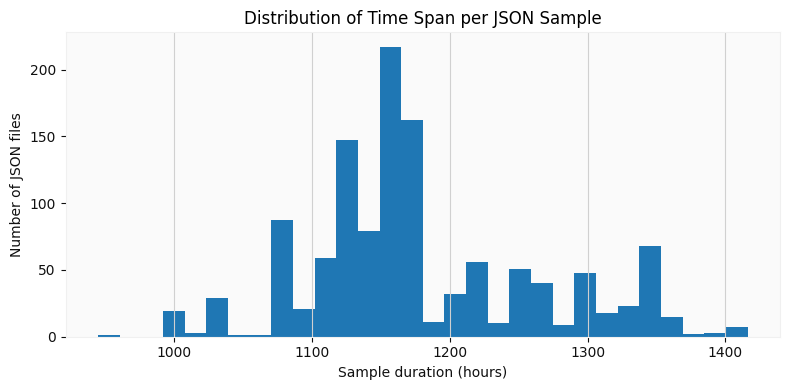

In [ ]:
durations_hours = []
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)

    candles = data.get("ohlcv_data", [])
    if len(candles) < 2:
        continue

    times = pd.to_datetime([c["time"] for c in candles])
    duration_hours = (times.max() - times.min()).total_seconds() / 3600

    durations_hours.append(duration_hours)

plt.figure(figsize=(8, 4))
plt.hist(durations_hours, bins=30)
plt.xlabel("Sample duration (hours)")
plt.ylabel("Number of JSON files")
plt.title("Distribution of Time Span per JSON Sample")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Missing time gaps
**Are candles continuous?**
- Distribution of time deltas between candles
- Flag missing intervals

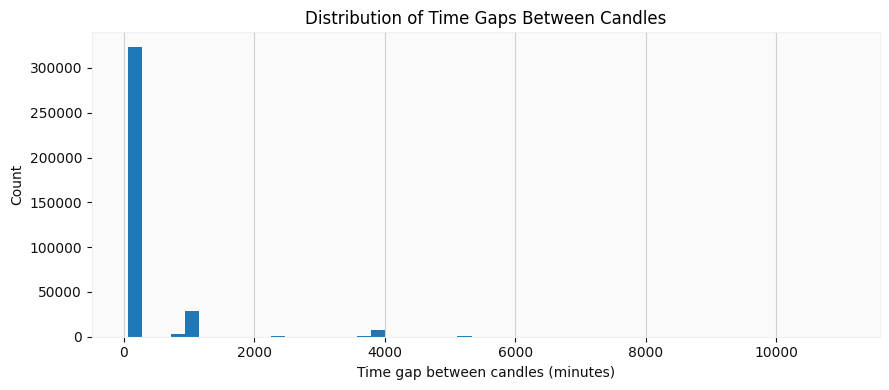

In [142]:
time_deltas_minutes = []
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)

    candles = data.get("ohlcv_data", [])
    if len(candles) < 2:
        continue

    times = pd.to_datetime([c["time"] for c in candles])
    times = times.sort_values()

    deltas = times.diff()[1:]
    deltas_minutes = deltas.total_seconds() / 60

    time_deltas_minutes.extend(deltas_minutes.tolist())

plt.figure(figsize=(9, 4))
plt.hist(time_deltas_minutes, bins=50)
plt.xlabel("Time gap between candles (minutes)")
plt.ylabel("Count")
plt.title("Distribution of Time Gaps Between Candles")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Open vs [Close, Low, High]
- To analyze intraday direction, volatility

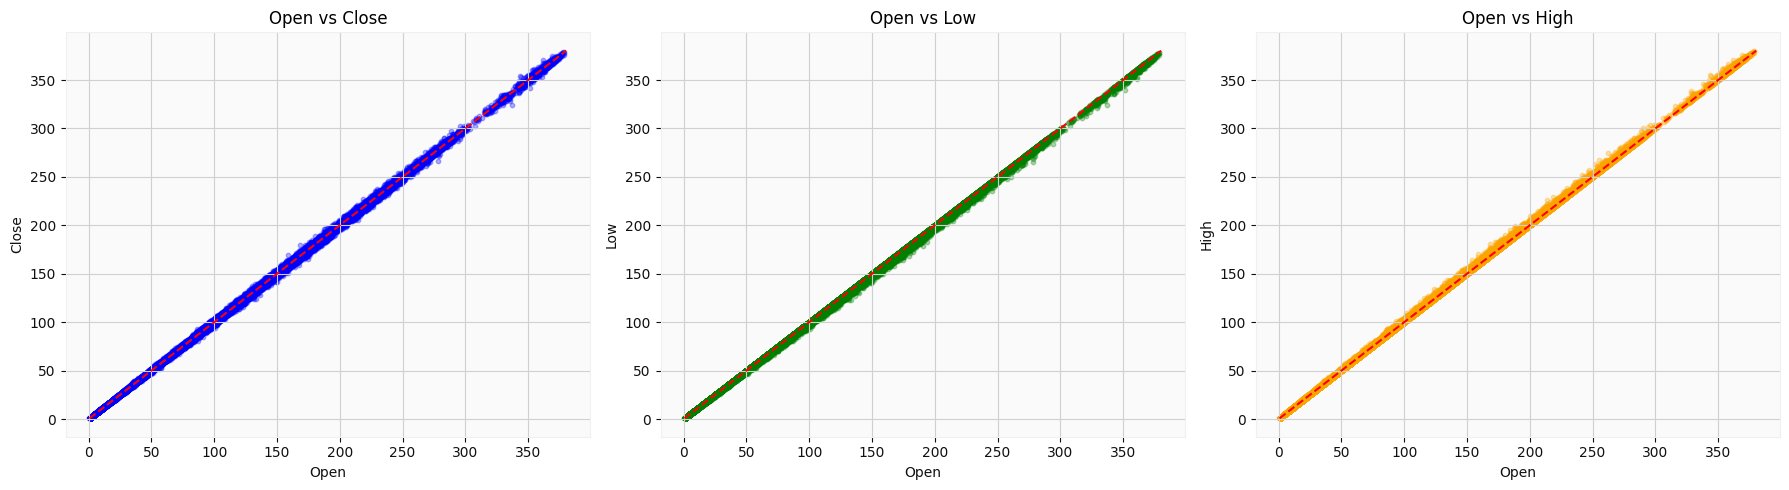

In [143]:
opens = []
closes = []
lows = []
highs = []
for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
    for candle in data.get("ohlcv_data", []):
        opens.append(candle["open"])
        closes.append(candle["close"])
        lows.append(candle["low"])
        highs.append(candle["high"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
min_price = min(opens + closes + lows + highs)
max_price = max(opens + closes + lows + highs)

# Open vs Close
axes[0].scatter(opens, closes, alpha=0.3, s=10, color='blue')
axes[0].plot([min_price, max_price], [min_price, max_price], linestyle="--", color='red')
axes[0].set_xlabel("Open")
axes[0].set_ylabel("Close")
axes[0].set_title("Open vs Close")
axes[0].grid(True)

# Open vs Low
axes[1].scatter(opens, lows, alpha=0.3, s=10, color='green')
axes[1].plot([min_price, max_price], [min_price, max_price], linestyle="--", color='red')
axes[1].set_xlabel("Open")
axes[1].set_ylabel("Low")
axes[1].set_title("Open vs Low")
axes[1].grid(True)

# Open vs High
axes[2].scatter(opens, highs, alpha=0.3, s=10, color='orange')
axes[2].plot([min_price, max_price], [min_price, max_price], linestyle="--", color='red')
axes[2].set_xlabel("Open")
axes[2].set_ylabel("High")
axes[2].set_title("Open vs High")
axes[2].grid(True)

plt.tight_layout()
plt.show()

### High − Low (intracandle volatility)

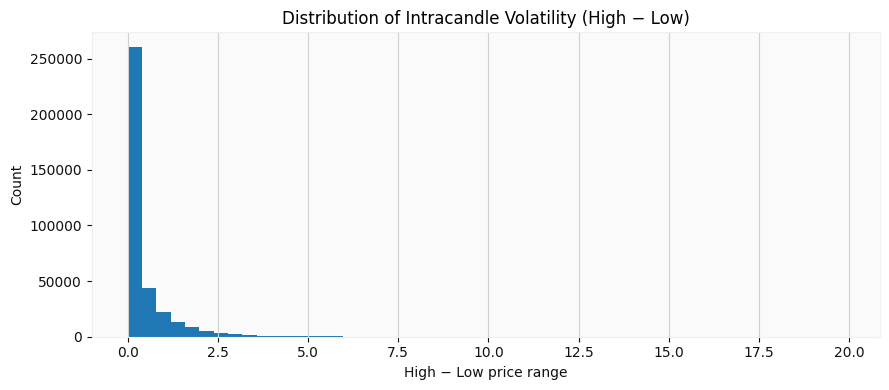

In [ ]:
intracandle_ranges = []
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)

    candles = data.get("ohlcv_data", [])
    if not candles:
        continue

    df = pd.DataFrame(candles)

    # Ensure numeric
    df["high"] = pd.to_numeric(df["high"], errors="coerce")
    df["low"] = pd.to_numeric(df["low"], errors="coerce")

    df = df.dropna(subset=["high", "low"])

    ranges = df["high"] - df["low"]
    intracandle_ranges.extend(ranges.tolist())

plt.figure(figsize=(9, 4))
plt.hist(intracandle_ranges, bins=50)
plt.xlabel("High − Low price range")
plt.ylabel("Count")
plt.title("Distribution of Intracandle Volatility (High − Low)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Volume vs volatility
**Does volume explain movement?**
- Scatter: volume vs (high − low)
- Scatter: volume vs |close − open|

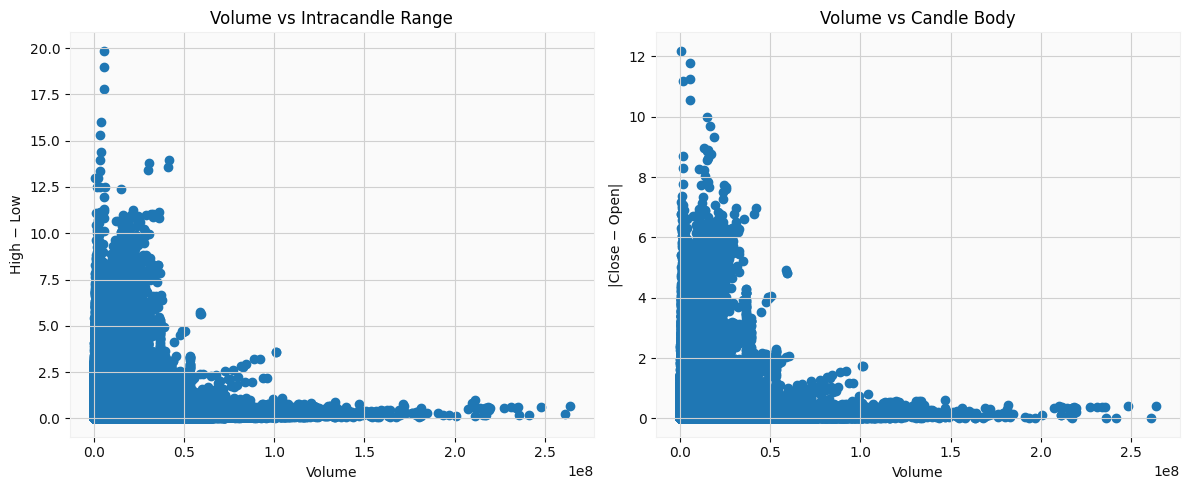

In [ ]:
volumes = []
high_low_ranges = []
abs_close_open = []
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)

    candles = data.get("ohlcv_data", [])
    if not candles:
        continue

    df = pd.DataFrame(candles)

    df["open"] = pd.to_numeric(df["open"], errors="coerce")
    df["high"] = pd.to_numeric(df["high"], errors="coerce")
    df["low"] = pd.to_numeric(df["low"], errors="coerce")
    df["close"] = pd.to_numeric(df["close"], errors="coerce")
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

    df = df.dropna(subset=["open", "high", "low", "close", "volume"])

    volumes.extend(df["volume"].tolist())
    high_low_ranges.extend((df["high"] - df["low"]).tolist())
    abs_close_open.extend((df["close"] - df["open"]).abs().tolist())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Chart 1
axes[0].scatter(volumes, high_low_ranges)
axes[0].set_xlabel("Volume")
axes[0].set_ylabel("High − Low")
axes[0].set_title("Volume vs Intracandle Range")
axes[0].grid(True)

# Chart 2
axes[1].scatter(volumes, abs_close_open)
axes[1].set_xlabel("Volume")
axes[1].set_ylabel("|Close − Open|")
axes[1].set_title("Volume vs Candle Body")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Feature correlation matrix

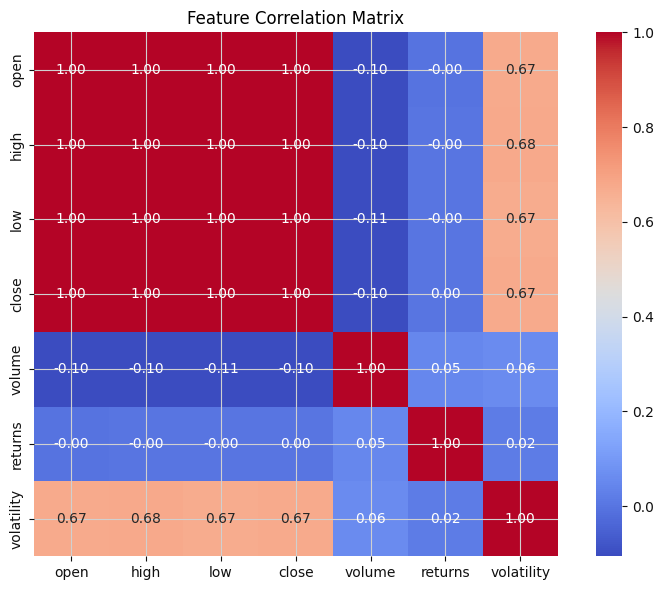

In [146]:
all_data = []
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)

    candles = data.get("ohlcv_data", [])
    if not candles:
        continue

    df = pd.DataFrame(candles)
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["open", "high", "low", "close", "volume"])
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)
df_all["returns"] = (df_all["close"] - df_all["open"]) / df_all["open"]
df_all["volatility"] = df_all["high"] - df_all["low"]
features = ["open", "high", "low", "close", "volume", "returns", "volatility"]
corr_matrix = df_all[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Chart Pattern Classification + Support/Resistance Detection